jupyter nbconvert 7_1_gcta_bivar.ipynb --to script


python 7_1_gcta_bivar.py $WINDOW

for i in {00..101};do python 6_gcta_uni.py $i;done

for i in {00..10};do python 4_association.py $i;done


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6292650/

In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import seaborn as sns

from pyplink import PyPlink

from basic_tools import *

In [2]:
log = logging.getLogger('logger')
log.setLevel(logging.DEBUG)

log_file_name=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+'.log'
log_file_path=data_out_gcta_path+log_file_name
fileHandler = logging.FileHandler(log_file_path)
streamHandler = logging.StreamHandler()

formatter = logging.Formatter(' %(asctime)s [%(levelname)s] %(lineno)d > %(message)s')
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)

log.addHandler(fileHandler)
log.addHandler(streamHandler)

In [3]:
result_uni=pd.read_csv(data_out_gcta_path+'result_uni.tsv',sep='\t',index_col=0)

In [4]:
grm_path='data/genotype/4_merge/KCHIP_HLA_AA_SNP_1000G.grm'

In [6]:
#np.all(pd.read_csv(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.phe',sep='\t',header=None)[2].isnull()|pd.read_csv(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.phe',sep='\t',header=None)[3].isnull())

In [25]:
rG_matrix_upper=np.zeros((len(result_uni),len(result_uni)))
rG_SE_matrix_upper=np.zeros((len(result_uni),len(result_uni)))

In [26]:
for i in range(0,len(result_uni)):
    for j in range(i+1,len(result_uni)):
        phenotype_name1=result_uni.iloc[i].name
        phenotype_name2=result_uni.iloc[j].name

        if phenotype_name1=='age' or phenotype_name2=='age':
            continue

        if os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.HEreg'):
            pass
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.HEreg'):
            (phenotype_name2,phenotype_name1)=phenotype_name1,phenotype_name2
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log'):
            with open(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log') as f:
                if 'no phenotype data is found' in f.read():
                    continue
        elif os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log'):
            with open(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log') as f:            
                if 'no phenotype data is found' in f.read():
                    continue            
        else:
            raise
            
        result1=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name1),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        result2=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name2),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #pd.read_csv(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.phe',sep='\t',header=None)
        
        result_bivar=pd.read_csv(data_out_gcta_path+'{}-{}.HEreg'.format(phenotype_name1,phenotype_name2),skiprows=[0,1],sep=r'\s+').set_index('Coefficient')
        rG_matrix_upper[i][j]=result_bivar.loc['rG']['Estimate']
        rG_SE_matrix_upper[i][j]=result_bivar.loc['rG']['SE_OLS']        
        

In [45]:
def make_tri(mat):
    upper1=np.triu(mat,k=1)
    upper2=np.triu(mat.T,k=1) 
    
    ret=upper1+upper2 - np.where((upper1==upper2), upper1, 0)
    ret=np.triu(ret,k=1)
    return ret

In [46]:
rG_matrix=make_tri(rG_matrix_upper)
rG_abs_matrix=np.abs(rG_matrix)
rG_SE_matrix=make_tri(rG_SE_matrix_upper)
rG_Z_abs_matrix=np.abs(rG_matrix/rG_SE_matrix)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [47]:
rG_matrix_df=pd.DataFrame(rG_matrix,index=result_uni.index,columns=result_uni.index)
rG_abs_matrix_df=pd.DataFrame(rG_abs_matrix,index=result_uni.index,columns=result_uni.index)
#rG_Z_matrix_df=pd.DataFrame(rG_Z_matrix,index=result_uni.index,columns=result_uni.index)
rG_Z_abs_matrix_df=pd.DataFrame(rG_Z_abs_matrix,index=result_uni.index,columns=result_uni.index)
rG_SE_matrix_df=pd.DataFrame(rG_SE_matrix,index=result_uni.index,columns=result_uni.index)

In [48]:
#rG_Z_abs_matrix_df

In [49]:
edges=rG_matrix_df.mask(np.tril(np.ones(rG_matrix_df.shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','rG'])

In [50]:
edges2=rG_Z_abs_matrix_df.mask(np.tril(np.ones(rG_Z_abs_matrix_df.shape)).astype(np.bool)).stack()
edges2=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges2.iteritems()],columns=['source','target','Z_abs'])

In [51]:
edges3=rG_abs_matrix_df.mask(np.tril(np.ones(rG_abs_matrix_df.shape)).astype(np.bool)).stack()
edges3=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges3.iteritems()],columns=['source','target','rG_abs'])

In [112]:
edges=edges.merge(right=edges2,left_on=['source','target'],right_on=['source','target']).merge(right=edges3,left_on=['source','target'],right_on=['source','target'])

In [113]:
edges_filtered=edges.sort_values('Z_abs',ascending=False).iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]

In [114]:
#edges_filtered=edges_filtered.sort_values('rG_abs',ascending=True)#.iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]
edges_filtered=edges_filtered[edges_filtered['rG_abs']>0.3]

In [115]:
groups=[]
for idx,row in edges_filtered.iterrows():
    try:
        group_index=[(row['source'] in groups[i] or row['target'] in groups[i]) for i in range(len(groups))].index(True)
        groups[group_index].add(row['source'])
        groups[group_index].add(row['target'])
    except:
        groups.append({row['source'],row['target']})

In [116]:
groups=sorted(groups,key=lambda x: len(x),reverse=True)

In [127]:
len(groups)

2

In [118]:
#phenotypes_par_filtered['group_id']=
edges_filtered['group_id']=[np.argmax([False]+[row['source'] in group for group in groups]) for idx,row in edges_filtered.iterrows()]

In [119]:
import networkx as nx

In [120]:
plt.rcParams['font.family']='Arial'

In [121]:
edges_filtered

,source,target,rG,Z_abs_x,rG_abs_x,Z_abs_y,rG_abs_y,Z_abs,rG_abs,group_id
2870,total_cholesterol,triglyceride,0.937109,39.356634,0.937109,39.356634,0.937109,39.356634,0.937109,1
2124,height,total_cholesterol,0.907208,24.411592,0.907208,24.411592,0.907208,24.411592,0.907208,1
2682,platelet,total_cholesterol,0.542554,23.525785,0.542554,23.525785,0.542554,23.525785,0.542554,1
2306,hyperlipidemia,triglyceride,0.969675,23.358346,0.969675,23.358346,0.969675,23.358346,0.969675,1
2304,hyperlipidemia,total_cholesterol,0.996971,23.176317,0.996971,23.176317,0.996971,23.176317,0.996971,1
2125,height,triglyceride,0.740879,22.856759,0.740879,22.856759,0.740879,22.856759,0.740879,1
1583,creatinine,triglyceride,0.766470,19.987066,0.766470,19.987066,0.766470,19.987066,0.766470,1
1582,creatinine,total_cholesterol,0.758200,18.721450,0.758200,18.721450,0.758200,18.721450,0.758200,1
2688,platelet,wbc,-0.334194,18.195152,0.334194,18.195152,0.334194,18.195152,0.334194,1
2774,rbc,triglyceride,0.671573,17.670695,0.671573,17.670695,0.671573,17.670695,0.671573,1


In [135]:
edges_filtered[edges_filtered['group_id']==2]

,source,target,rG,Z_abs_x,rG_abs_x,Z_abs_y,rG_abs_y,Z_abs,rG_abs,group_id
398,alt,ast,0.717702,8.044084,0.717702,8.044084,0.717702,8.044084,0.717702,2


In [136]:
edges_filtered_filtered=edges_filtered[edges_filtered['group_id']==1]
#edges_filtered_filtered=edges_filtered

G_temp=nx.convert_matrix.from_pandas_edgelist(edges_filtered_filtered,edge_attr=['rG','rG_abs','Z_abs'])

#per_bp_var_temp=per_bp_var.copy()
#per_bp_var_temp.index=per_bp_var_temp.index.map(lambda x:description_to_short(code_to_description(x),'pub',2))
nx.set_node_attributes(G_temp,dict([(node,pd.Series(result_uni['V(G)/Vp-Estimate'].loc[node]).iloc[0]) for node in list(G_temp.nodes)]),'heritability')
#nx.set_node_attributes(G_temp,dict([(node,node) for node in list(G.nodes)]),'label')

In [137]:
#G.edges['triglyceride', 'total_cholesterol']

In [138]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=G_temp.copy()#nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
pos = nx.kamada_kawai_layout(G,weight='Z_abs')

In [139]:
plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams["font.size"] = 10
#sns.heatmap(rG_matrix_df, annot=True,cmap=plt.get_cmap('PiYG'),center=0,vmin=-1,vmax=1)

# Network

## unique

# New

In [140]:
import random

angle_map=lambda x: (np.arctan(x[1]/x[0])+(np.pi if x[0]<0 else 0)+2*np.pi)%(2*np.pi)

def draw_arc(a,b):

    center=(a+b)/2+(1 if random.random()>0.5 else -1)*np.array([(b-a)[1],-(b-a)[0]])*random.uniform(np.sqrt(3)/2,2)

    radius=np.sqrt(np.power(b-center,2).sum())

    a_theta=angle_map(a-center)#arctan_norm((a-center)[1]/(a-center)[0])
    b_theta=angle_map(b-center)
    
    if abs(b_theta-a_theta)>np.pi:
        if a_theta>b_theta:
            a_theta=a_theta-2*np.pi
        else:
            b_theta=b_theta-2*np.pi
            
    try:
        return [center+radius*np.array([np.cos(theta),np.sin(theta)]) for theta in np.arange(min(a_theta,b_theta),max(a_theta,b_theta),abs(b_theta-a_theta)/100)]
    except:
        print('error')
        return [a,b]

#draw_arc(np.array((0,1)),np.array((1,0)))

In [142]:
#edge_df.sort_values('rG')

<Figure size 1080x1440 with 0 Axes>

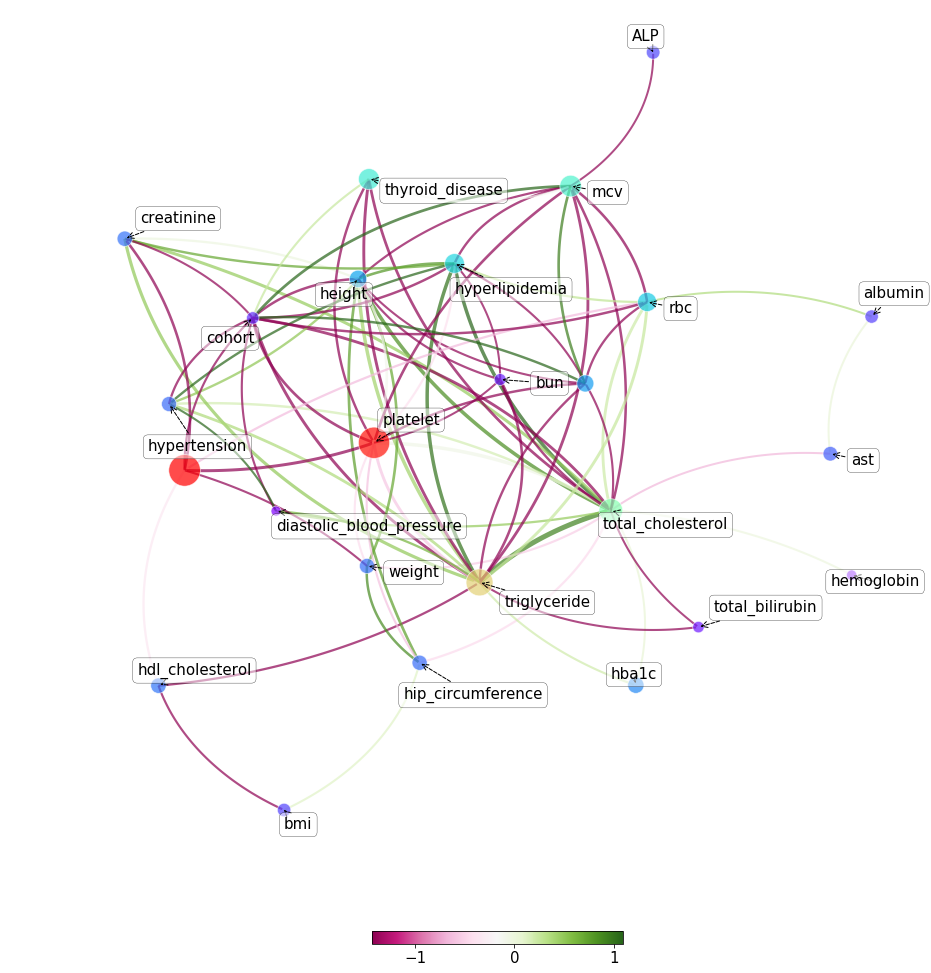

In [141]:
node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (15,20)
plt.rcParams["font.size"] = 15


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#,[
scatter_x=[i[0] for i in edge_df['source_xy'].values]
scatter_y=[i[1] for i in edge_df['source_xy'].values]
scatter_hue=edge_df[edge_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
  

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.PiYG(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
sns.scatterplot(x=scatter_x,y=scatter_y,hue=scatter_hue,palette=plt.cm.rainbow,vmin=-1,alpha=0.7,size=scatter_size,sizes=(100,1000),legend=None)#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    description_short=idx
    
    s=description_short
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

plt.show()



/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


error
error
error


<Figure size 1440x1800 with 0 Axes>

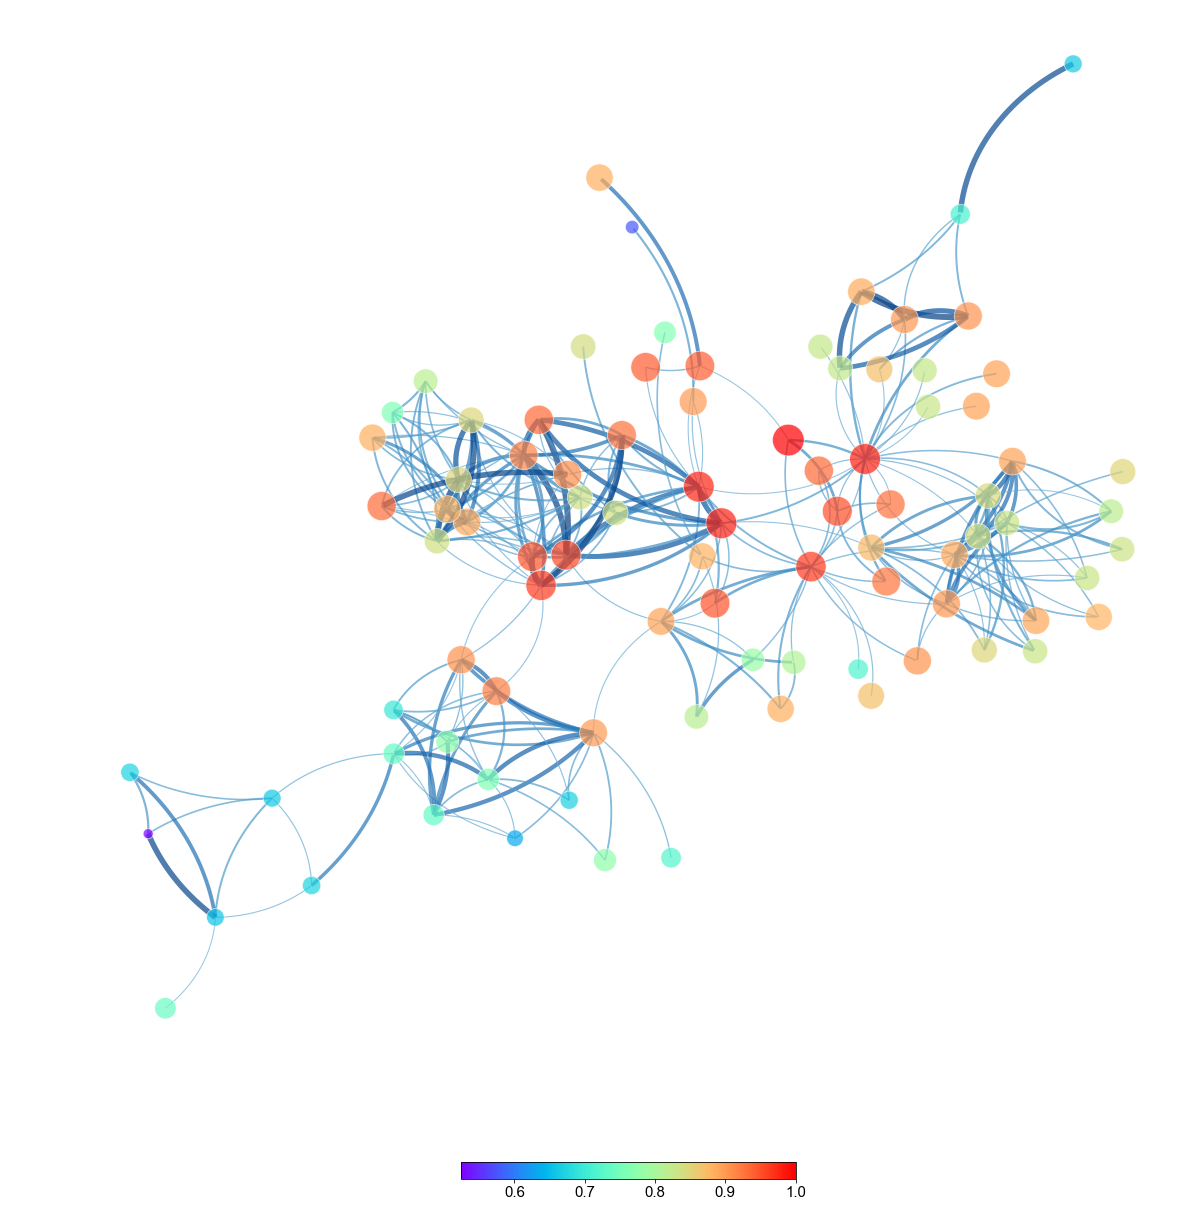

In [42]:
node_color='per_bp_var'
node_size='per_bp_var'
edge_width='value'
edge_color='value'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (20,25)
plt.rcParams["font.size"] = 15


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
        
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.rainbow)
        
plt.clf()

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths

line_collection_colors=np.array([plt.cm.Blues(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
sns.scatterplot(x=scatter_x,y=scatter_y,hue=scatter_hue,palette=plt.cm.rainbow,alpha=0.7,size=scatter_size,sizes=(100,1000),legend=None)#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    description_short=idx
    
    s=description_short
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    move=move_sample[0]
    xytext=xy+move
    #plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
    

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')
plt.savefig('network.svg')

plt.show()



/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


error
error
error


<Figure size 1440x1800 with 0 Axes>

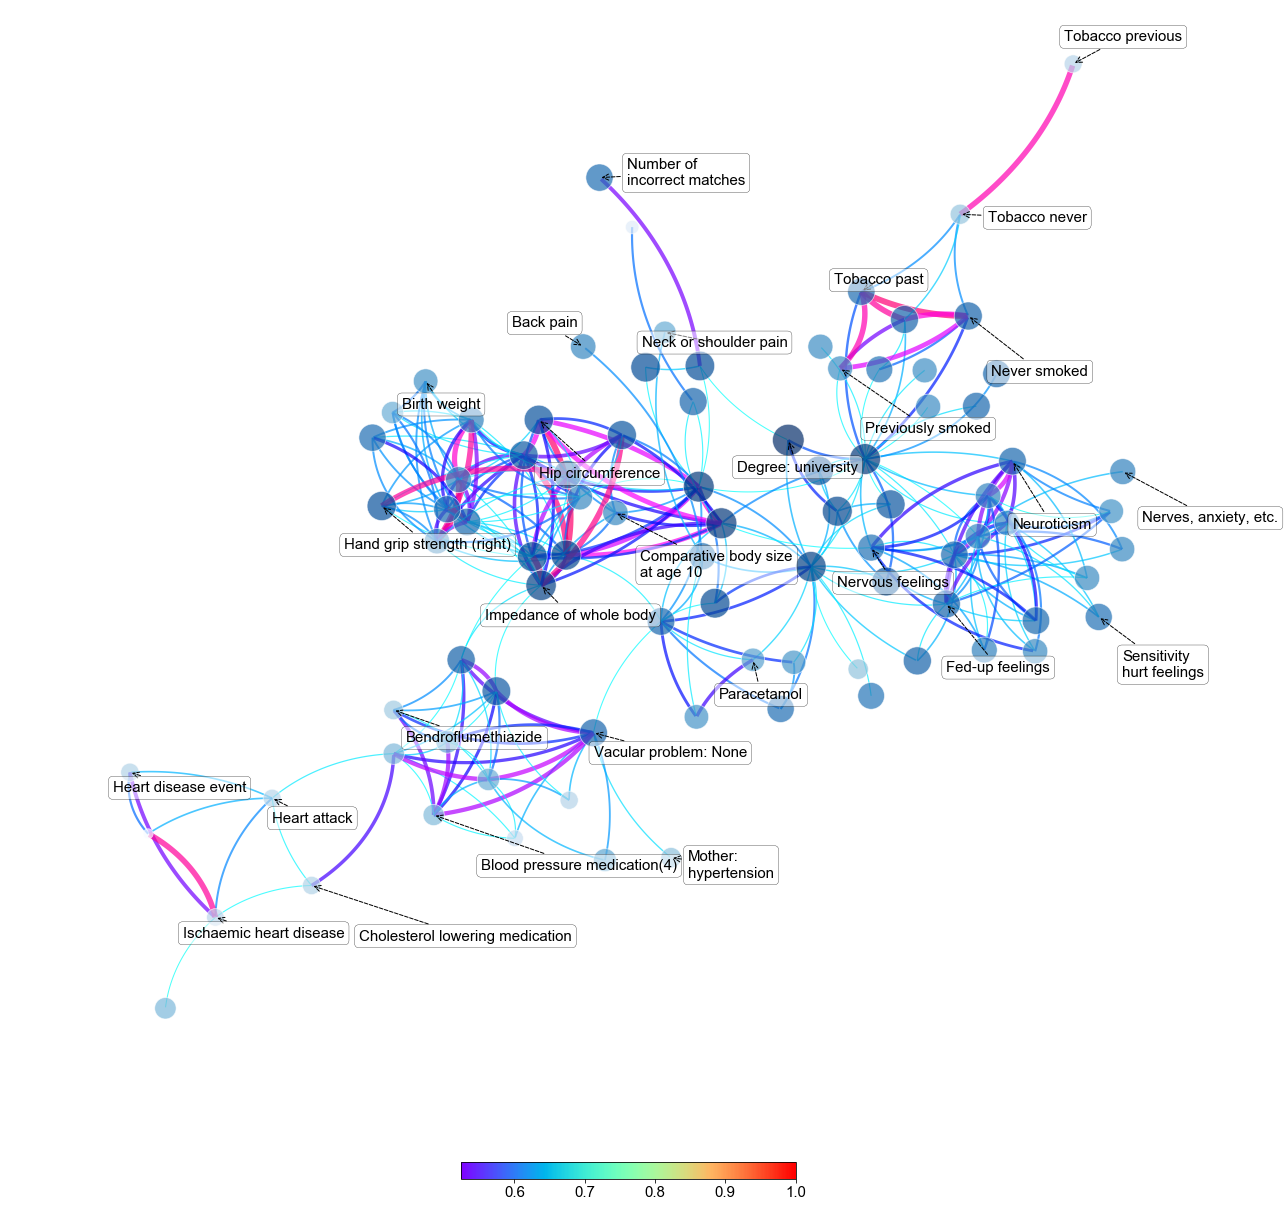

In [36]:
node_color='per_bp_var'
node_size='per_bp_var'
edge_width='value'
edge_color='value'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (20,25)
plt.rcParams["font.size"] = 15


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
        
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.rainbow)
        
plt.clf()

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths

line_collection_colors=np.array([plt.cm.hsv(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
sns.scatterplot(x=scatter_x,y=scatter_y,hue=scatter_hue,palette=plt.cm.Blues,alpha=0.7,size=scatter_size,sizes=(100,1000),legend=None)#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    description_short=idx
    
    s=description_short
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0",ls='dashed'),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0.5), ec="black", lw=0.3),size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

plt.show()



In [37]:
line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=1+5*line_collection_linewidths
